In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
train_df = pd.read_csv('train.csv', sep = ',')
test_df = pd.read_csv('test.csv', sep = ',')

# EDA

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot:>

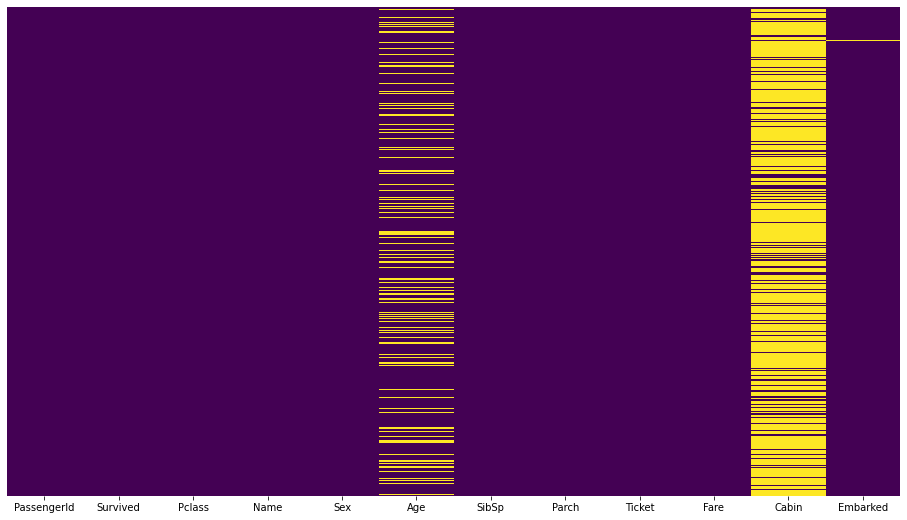

In [4]:
plt.figure(figsize = (16, 9))
sns.heatmap(train_df.isnull(), cbar = False , 
            yticklabels = False , cmap = 'viridis')

<AxesSubplot:>

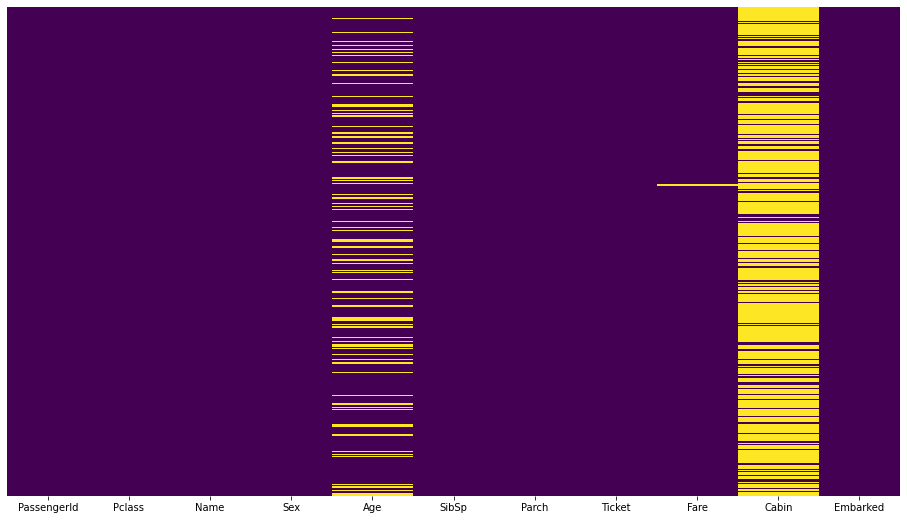

In [5]:
plt.figure(figsize = (16, 9))
sns.heatmap(test_df.isnull(), cbar = False , 
            yticklabels = False , cmap = 'viridis')

In [6]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


We can already see that Cabin class is almost empty, so we can safeley drop it, as well as "Name" and "Ticket" as they both identified by other parameters, like "Sex", "Age", "SibSp" for people identification and "Fare", "Pclass" and "Embarked" for tickets.

Agewise we can fill missing values with median value

## Age and Sex to target

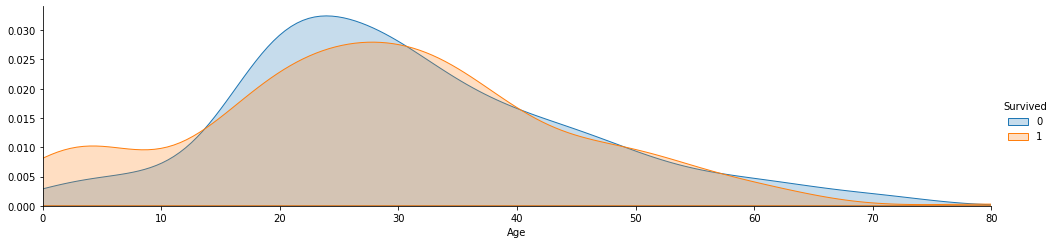

In [7]:
fig = sns.FacetGrid(train_df, hue = 'Survived', aspect = 4, size = 3.5)
fig.map(sns.kdeplot, 'Age' , shade = True)
fig.set(xlim = (0, train_df['Age'].max()))
fig.add_legend()

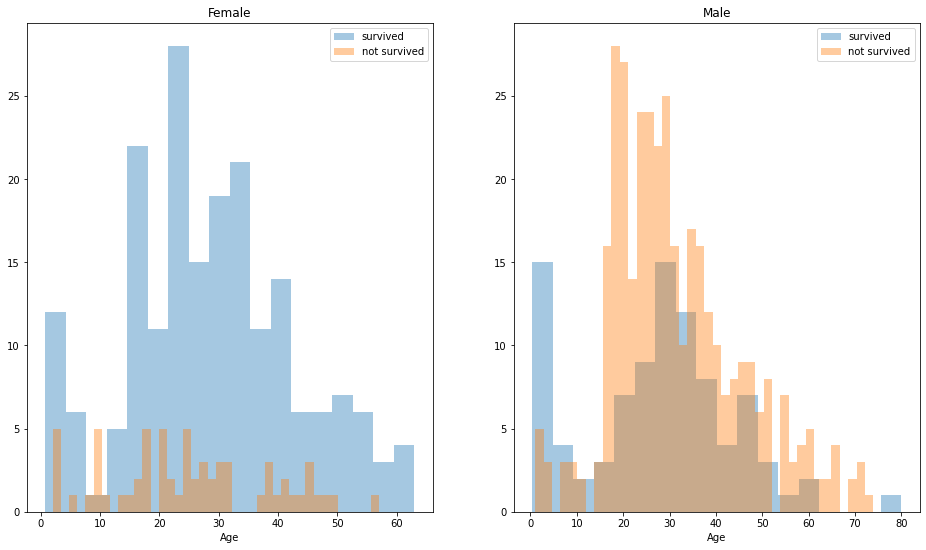

In [8]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 9))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

## Embarked, Pclass and relatives features to target

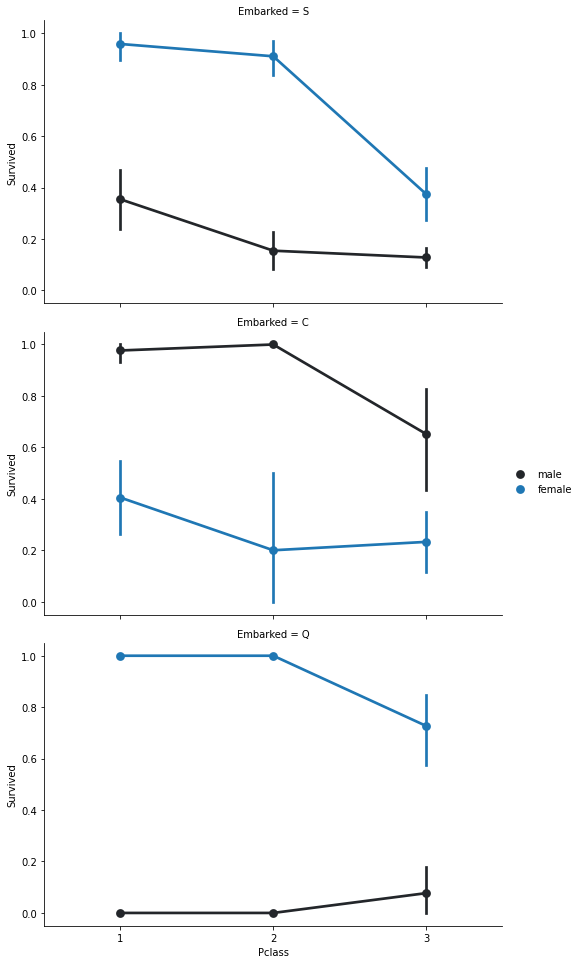

In [9]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

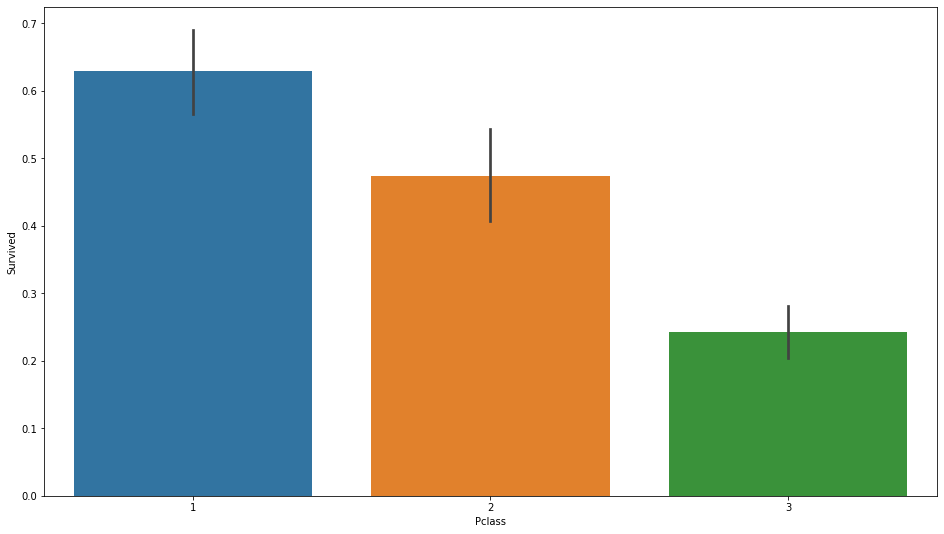

In [10]:
plt.figure(figsize = (16, 9))
sns.barplot(x='Pclass', y='Survived', data=train_df)

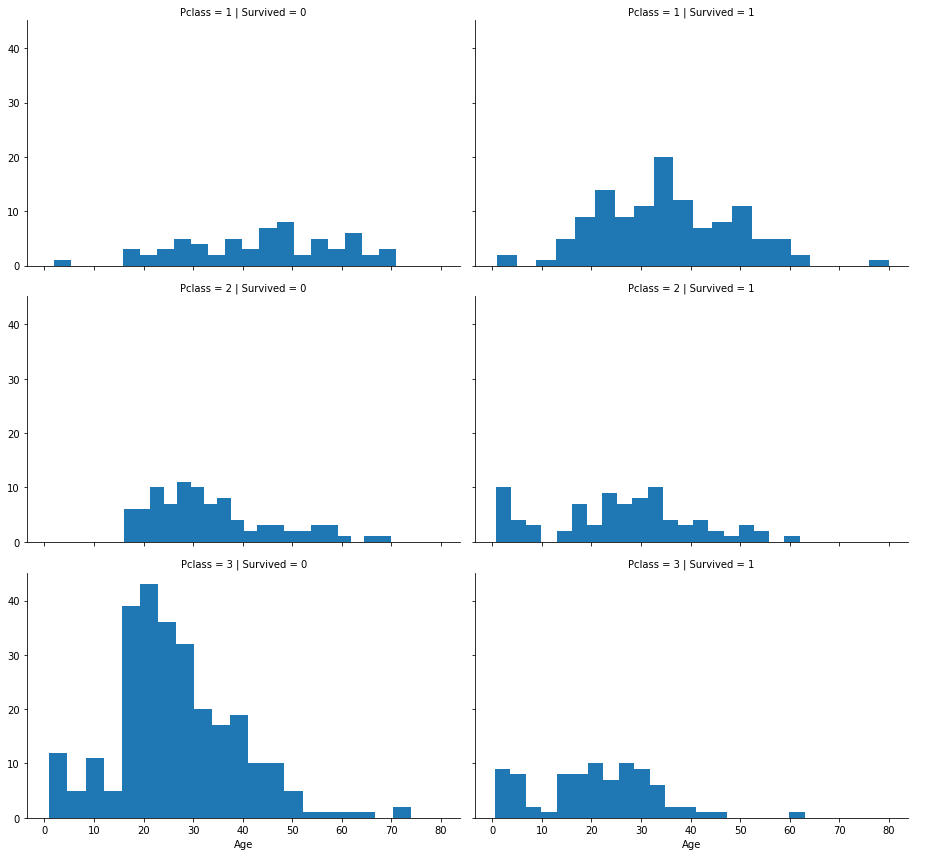

In [11]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=4, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=1, bins=20)
grid.add_legend();

In [12]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

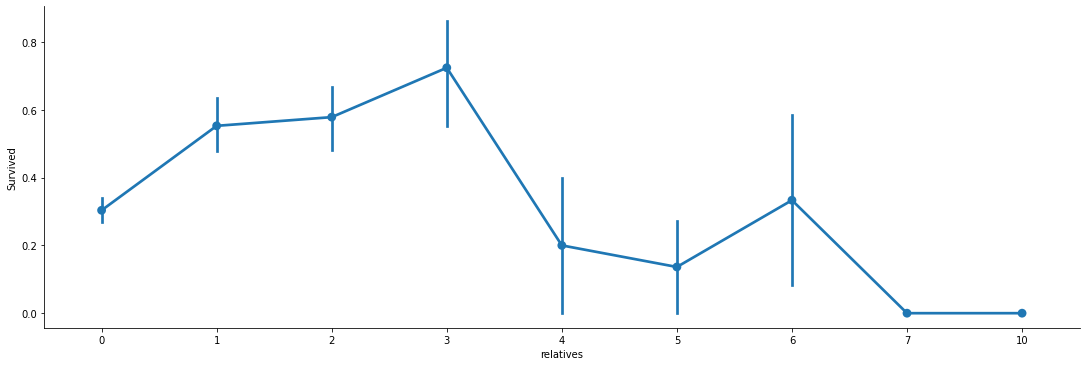

In [13]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 3)

# Data preprocessing

In [14]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,not_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [15]:
train_df=train_df.drop(['Name'], axis = 1)
test_df=test_df.drop(['Name'], axis = 1)

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,not_alone
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [17]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [18]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

In [19]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [20]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    int32  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  relatives    891 non-null    int64  
 11  not_alone    891 non-null    int32  
 12  Deck         891 non-null    int32  
dtypes: float64(1), int32(3), int64(6), object(3)
memory usage: 80.2+ KB


In [22]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [23]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [24]:
train_df['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [25]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [26]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [27]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck
0,1,0,3,0,22,1,0,7,0,1,0,8
1,2,1,1,1,38,1,0,71,1,1,0,3
2,3,1,3,1,26,0,0,7,0,0,1,8
3,4,1,1,1,35,1,0,53,0,1,0,3
4,5,0,3,0,35,0,0,8,0,0,1,8


# Modeling

* Quick modeling with supervised learning
* Clustering methods
    * K-means
    * AgglomerativeClustering

## Logistic Regrssion

In [28]:
X_train = train_df.drop("Survived", axis=1)
X_test  = test_df
Y_train = train_df["Survived"]

In [29]:
train_split_x, validate_x, train_split_y, validate_y =train_test_split(X_train, Y_train, test_size=0.2)

In [30]:
clf = LogisticRegression()

clf.fit(train_split_x, train_split_y)

train_preds = clf.predict(train_split_x)
print(classification_report(train_split_y, train_preds))
print("ROC AUC score is: ",roc_auc_score(train_split_y, train_preds))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       444
           1       0.77      0.66      0.71       268

    accuracy                           0.80       712
   macro avg       0.79      0.77      0.78       712
weighted avg       0.80      0.80      0.80       712

ROC AUC score is:  0.7735309936802474


In [32]:
result_predi = clf.predict(X_test)
results = pd.DataFrame()
results['PassengerId'] = test_df['PassengerId']
results['Survived'] = result_predi

In [33]:
results

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [34]:
results = results.to_csv('LogReg.csv',index = False)
#kaggle score 0.76555

## Clustering

In [39]:
def plotter(data, color):
    plt.scatter(data[:,0],data[:,1], c=color, cmap='plasma')

In [40]:
train_x_clst = X_train
test_x_clst = X_test

In [37]:
perplexity_value = 50

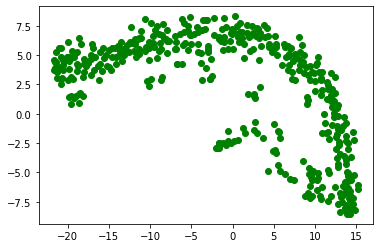

In [41]:
tsne = TSNE(perplexity=perplexity_value, 
            n_iter=1000, random_state=30)
tsne_transform = tsne.fit_transform(test_x_clst)
plotter(tsne_transform, "green")

### K-means

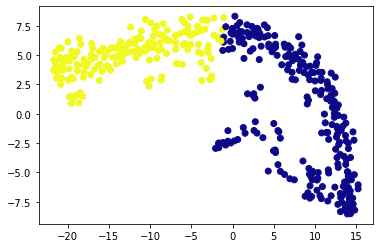

In [42]:
clf = KMeans(n_clusters=2)
labels = clf.fit(tsne_transform).labels_
plotter(tsne_transform, labels)

In [44]:
result_predi = clf.fit_predict(X_test)
results = pd.DataFrame()
results['PassengerId'] = test_df['PassengerId']
results['Survived'] = result_predi

In [45]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,1
414,1306,1
415,1307,1
416,1308,1


In [46]:
#kaggle score 0.48086
results = results.to_csv('KMeans.csv',index = False)

### Agglomerative Clustering

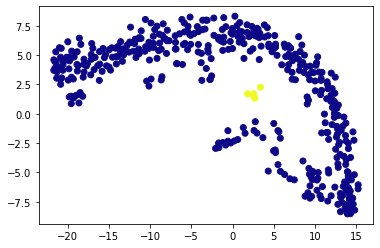

In [47]:
clf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage="single")
labels = clf.fit(tsne_transform).labels_
plotter(tsne_transform, labels)

In [50]:
result_predi = clf.fit_predict(X_test)
results = pd.DataFrame()
results['PassengerId'] = test_df['PassengerId']
results['Survived'] = result_predi

In [51]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [52]:
#kaggle single link score 0.62440
results = results.to_csv('SingleLink.csv',index = False)

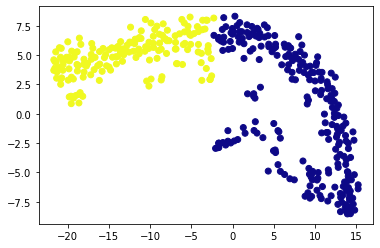

In [53]:
clf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage="complete")
labels = clf.fit(tsne_transform).labels_
plotter(tsne_transform, labels)

In [55]:
result_predi = clf.fit_predict(X_test)
results = pd.DataFrame()
results['PassengerId'] = test_df['PassengerId']
results['Survived'] = result_predi

In [56]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [57]:
#kaggle complete link score 0.62440
results = results.to_csv('CompleteLink.csv',index = False)

![image](result.png)